In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle 

In [2]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Load your data
df = pd.read_csv('data_preprocessing.csv')

print("Data shape:", df.shape)
print(df.head())

Data shape: (903, 6)
                                         ingredients  combination  dry  \
0  algae extract, mineral oil, petrolatum, glycer...            1    1   
1  galactomyces ferment filtrate , butylene glyco...            1    1   
2  water, dicaprylyl carbonate, glycerin, ceteary...            1    1   
3  algae extract, cyclopentasiloxane, petrolatum,...            1    1   
4  water, snail secretion filtrate, phenyl trimet...            1    1   

   normal  oily  sensitive  
0       1     1          1  
1       1     1          1  
2       1     1          0  
3       1     1          1  
4       1     1          1  


In [3]:
# MultiLabelBinarizer untuk encoding target
mlb = MultiLabelBinarizer()

# Mengonversi kolom tipe kulit menjadi daftar label
labels = []
for _, row in df[['combination', 'dry', 'normal', 'oily', 'sensitive']].iterrows():
    labels.append(row.index[row == 1].tolist())  # Ambil nama kolom dengan nilai 1

# Binarisasi label
y = mlb.fit_transform(labels)

# Hasil encoding
print("Target shape (y):", y.shape)  # Output: (num_samples, 5)
print("Classes:", mlb.classes_)  # Output: ['combination', 'dry', 'normal', 'oily', 'sensitive']
print("First 5 samples of y:")
print(y[:5])  # Preview 5 data pertama


Target shape (y): (903, 5)
Classes: ['combination' 'dry' 'normal' 'oily' 'sensitive']
First 5 samples of y:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 0]
 [1 1 1 1 1]
 [1 1 1 1 1]]


In [5]:
# Tokenizer untuk kolom 'ingredients'
tokenizer = Tokenizer(num_words=5000)  # Batasi jumlah kata yang digunakan menjadi 5000
tokenizer.fit_on_texts(df['ingredients'])  # Fit tokenizer dengan data teks

# Ubah kalimat menjadi urutan angka
X = tokenizer.texts_to_sequences(df['ingredients'])

# Padding untuk memastikan panjang input konsisten
X = pad_sequences(X, padding='post', maxlen=100)  # Maxlen disesuaikan dengan panjang input yang diinginkan

# Menampilkan preview hasil tokenisasi dan padding
print("Shape of X:", X.shape)

# Save tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Shape of X: (903, 100)


In [6]:
# Membagi data menjadi data latih dan data validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Menampilkan shape data setelah pembagian
print("Train data shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Validation data shape (X_val, y_val):", X_val.shape, y_val.shape)


Train data shape (X_train, y_train): (632, 100) (632, 5)
Validation data shape (X_val, y_val): (271, 100) (271, 5)


In [7]:
# Function to create the model
def create_model(vocab_size, embedding_dim, max_length):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(5, activation='sigmoid')  # Use 'sigmoid' for multi-label classification
    ])
    
    # Build the model with a dummy input shape to initialize it
    model.build(input_shape=(None, max_length))  # None is for batch size, max_length is input sequence length
    
    model.compile(loss='binary_crossentropy',  # Use binary_crossentropy for multi-label classification
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])
    
    return model


In [8]:
# Set parameters
vocab_size = 5000
embedding_dim = 64
max_length = 100

# Create model
model = create_model(vocab_size, embedding_dim, max_length)

# Display model summary
model.summary()

e:\flask\ocr_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,797 (1.35 MB)

 Trainable params: 353,797 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Callback untuk menghentikan pelatihan lebih awal jika validasi loss tidak membaik
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Melatih model
epochs = 50
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.1484 - loss: 0.6460 - val_accuracy: 0.0000e+00 - val_loss: 0.3331
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3387 - loss: 0.3149 - val_accuracy: 0.9668 - val_loss: 0.3079
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9762 - loss: 0.3075 - val_accuracy: 0.9668 - val_loss: 0.3039
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9753 - loss: 0.3065 - val_accuracy: 0.9668 - val_loss: 0.3024
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9733 - loss: 0.2990 - val_accuracy: 0.9668 - val_loss: 0.3028
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9668 - loss: 0.3046 - val_accuracy: 0.9668 - val_loss: 0.3035
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9714 - loss: 0.2921 - val_accuracy: 0.9668 - val_loss: 0.3033
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9650 - loss: 0.3124 - val_accuracy: 0.9668

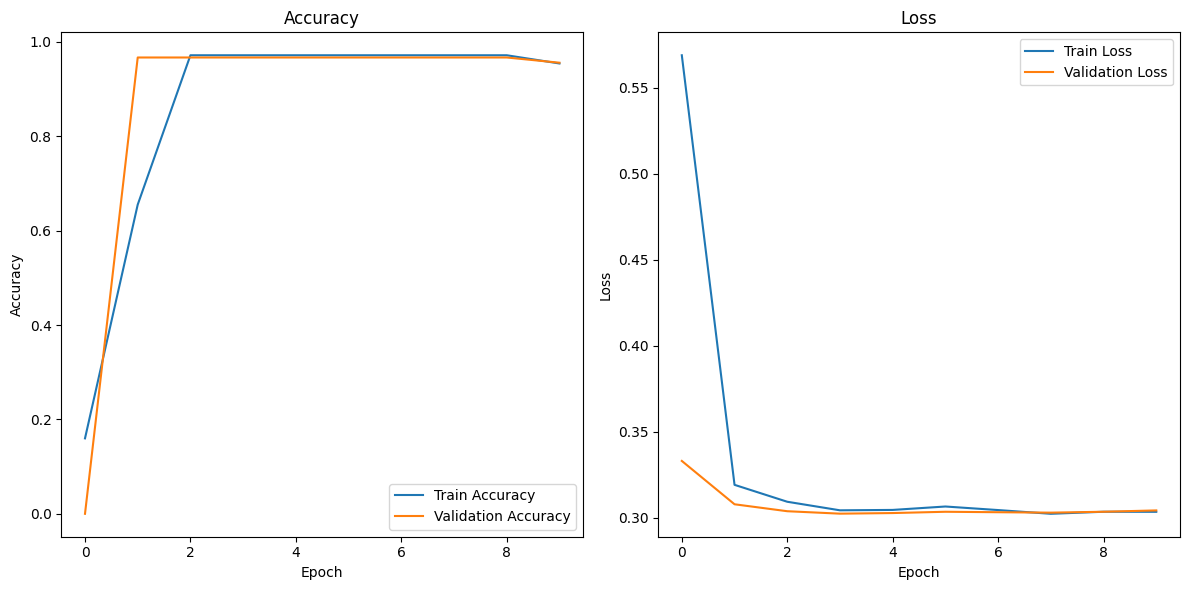

In [10]:
# Menampilkan grafik hasil pelatihan
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9759 - loss: 0.2996
Validation Loss: 0.302439421415329
Validation Accuracy: 0.9667896628379822


In [14]:
model.save('model.h5')